In [1]:
import os, sys, collections
import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
from colour import Color

In [2]:
from tf.app import use
B = use('bhsa', hoist=globals())

Using etcbc/bhsa/tf - c r1.4 in C:\Users\Ejer/text-fabric-data
Using etcbc/phono/tf - c r1.1 in C:\Users\Ejer/text-fabric-data
Using etcbc/parallels/tf - c r1.1 in C:\Users\Ejer/text-fabric-data


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of BHSA = Biblia Hebraica Stuttgartensia Amstelodamensis">BHSA</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Writing/Hebrew" title="('Hebrew characters and transcriptions',)">Character table</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="bhsa API documentation">bhsa API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 7.0.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [3]:
file = 'Datasets/Lev17toLev26_mapped_updated.csv'
data = pd.read_csv(file)

In [4]:
data[:10]

,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
0,1,JDBR,Leviticus,17,1,528163,DBR,DBR,3sm=JHWH,JHWH,63009,VbPred,0
1,2,JHWH,Leviticus,17,1,528163,DBR,JHWH,3sm=JHWH,JHWH,63010,Subj,1
2,3,>L MCH,Leviticus,17,1,528163,DBR,>L MCH,0sm=MCH,MCH,63011 63012,Compl1,2
3,4,L->MR,Leviticus,17,1,528164,>MR,L >MR,3sm=JHWH,JHWH,63013 63014,VbPred,3
4,5,DBR,Leviticus,17,2,528165,DBR,DBR,2sm=,MCH,63015,VbPred,4
5,6,>L >HRN W->L BNJW W->L KL BNJ JFR>L,Leviticus,17,2,528165,DBR,>L >HRN W >L BN+S W >L KL BN JFR>L,3pm=>HRN BN+>HRN FR>L,>HRN BN >HRN,63016 63017 63018 63019 63020 63021 63022 6302...,Compl1,5 6 7 8 9 10 11
6,7,>L >HRN W->L BNJW,Leviticus,17,2,528165,DBR,>L >HRN W >L BN+S,...,...,63016 63017 63018 63019 63020,-paral,6 7 8 9
7,8,>L >HRN,Leviticus,17,2,528165,DBR,>L >HRN,3sm=>HRN,>HRN,63016 63017,-paral,7
8,9,>L BNJW,Leviticus,17,2,528165,DBR,>L BN+312,...,...,63019 63020,-paral,8 9
9,10,sfx:W,Leviticus,17,2,528165,DBR,sfx,3sm=>HRN,>HRN,63020,-gentf,9


## Infinitive constructs

For some reason, infinitive constructs are annotated in the dataset with participant references, despite their lack of person, gender and number. However, there might be a linking pattern that suggests a consistent annotation of infinitive constructs.

First, we find all infcs in Lev 17-26 apart from those with a subject suffix:

In [25]:
query = '''
book book=Leviticus
  chapter chapter=17|18|19|20|21|22|23|24|24|26
    phrase function#PreS
      word vt=infc
'''
results = B.search(query)
B.show(results, end=5)

  1.30s 71 results




**verse** *1*





**verse** *2*





**verse** *3*





**verse** *4*





**verse** *5*



We assume that infinitive constructs will most likely link to the subject or the implicit subject (i.e. the predicate/predicate complement) of its [mother clause](https://etcbc.github.io/bhsa/features/hebrew/c/mother), that is, the clause to which the infinitive clause is dependent.

The following function has two steps. First, it looks for a subject, predicate, or predicate complement antecedent in the immediate mother clause. If the first step gives no result, the second step will look for the nearest antecedent in terms of rows in the dataset.

In [26]:
def infcAntecedent(row):
    '''
    Input: row number
    Output: Line and function of first preceding (implicit) subject, or the nearest antecedent.
    '''
    output = None
    
    actor_infc = data.iloc[row].actor
    mother_clause_atom = E.mother.f(data.iloc[row].clause_atom)[0] #Finding the mother clause atom.
    
    mother_clause_data = data[data.clause_atom == mother_clause_atom] #Creating a subset of the dataset for the mother clause.
    
    ## 1: Looping over the mother clause dataset in reverse order to find the nearest antecedent:
    for line in reversed(mother_clause_data.index):
        if data.iloc[line].func in ['Subj','VbPred','PrCompl']:
            if data.iloc[line].actor == actor_infc: #Checking whether the actor of the Subj, Pred or PreC is the same as the infc.
                output = row, line, data.iloc[line].func
                break
    
    ## 2: If step one did not provide an output the dataset is looped over backwards from the infc to find the nearest antec.
    if output == None:
        line = row-1
        while line >= 0:
            if data.iloc[line].actor == actor_infc:
                output = row, line, data.iloc[line].func
                break
        
            line -= 1
        
    return output

The function above is applied to each infc of the result tuple generated by the query above. First, however, the slots occupied by the infc is matched with identical slots of the dataset to find the relevant rows of the dataset containing infcs (the dataset does not specify verb tense, only phrase function):

In [27]:
func_list = []

for r in results: #Looping over the results of the query
    phrase = r[2]
    word_string = ''
    for w in L.d(phrase, 'word'): #Creating a string of word nodes
        word_string += f'{w} '
    row_infc = data.loc[data.slots == word_string.rstrip()].index[0] #Creating a subset of the dataset based on the wordstring.
    func_list.append(infcAntecedent(row_infc)) #Finding the function of the antecedent and appending it to func_list
    
#func_list

We want to investigate, how often an infinitive construct links to a subject, predicate or predicate complement in its immediate syntactic context (mother clause or preceding clause(s)). Therefore we count the syntactic functions contained in func_list and plot them in terms of frequency.

In [28]:
new_func_list = [e[2] for e in func_list]
new_func_list = collections.Counter(new_func_list)
table = pd.DataFrame.from_dict(new_func_list, orient='index')
table.columns = ['Function']

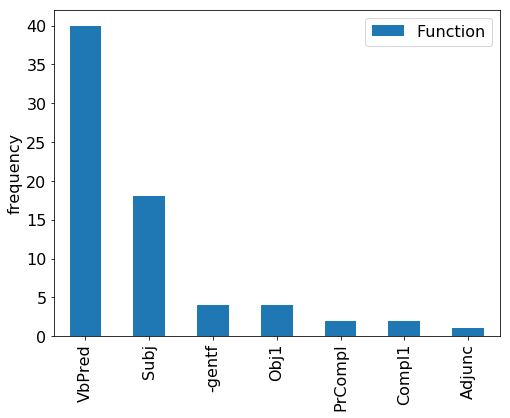

In [36]:
plot = table.sort_values(by='Function', ascending=False).plot(kind='bar')
plot.legend(fontsize = 16)
plt.xticks(fontsize=16)
plt.ylabel('frequency', fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = [8,6]
plt.show()

As expected, subject and predicate antecedents dominate and are probably the default mode of linking infitive constructs to other participant references in the dataset. Let's take a look at the other cases.

### Inspecting infrequent cases:

Number of infrequent cases:

In [26]:
n = 0
for e in func_list:
    if e[2] not in ['Subj','VbPred','PrCompl']:
        n+=1

print(f'Number of infrequent cases: {n}')

Number of infrequent cases: 11


We inspect the 11 infrequent cases manually by printing a subset of the dataset spanning the rows from the calculated antecedent to the infinitive construct. In addition, the verse is printed with the text-fabric function pretty():

In [368]:
for e in func_list:
    if e[2] not in ['Subj','VbPred','PrCompl']:
        row_infc = e[0]
        row_ant = e[1]
        bo, ch, ve = data.iloc[row_infc].book, data.iloc[row_infc].chapter, data.iloc[row_infc].verse #book, verse, chapter
        
        #Creating a list of word slots for both the infc and its antecedent
        slot_list = data.iloc[row_infc].slots.split() + data.iloc[row_ant].slots.split()
        color_dict = {int(n): 'gold' for n in slot_list} #The slot_list is transformed into a dictionary used for colorcoding
        
        display(data.iloc[e[1]:e[0]+1])
        B.pretty(T.nodeFromSection((bo, ch, ve)), highlights=color_dict)

,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
160,161,sfx:KM,Leviticus,17,11,528202,NTN,sfx,2pm=,BN JFR>L,63255,Adjunc,160
161,162,<L H-MZBX,Leviticus,17,11,528202,NTN,<L H MZBX,0sm=MZBX,MZBX,63256 63257 63258,Compl1,161
162,163,L-KPR,Leviticus,17,11,528203,KPR,L KPR,2pm=,BN JFR>L,63259 63260,VbPred,162


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
669,81,sfx:KM,Leviticus,19,9,528364,B QYR,sfx,2pm=,BN JFR>L,63935,-gentf,669
670,82,TKLH,Leviticus,19,9,528365,KLH,KLH,2sm=,"2sm""YOUSgmas""",63937,VbPred,670
671,83,P>T FDK,Leviticus,19,9,528365,KLH,P>H FDH+S,...,...,63938 63939,Obj1,671 672 673
672,84,FDK,Leviticus,19,9,528365,KLH,FDH+212,"0sm=FDH+2sm""YOUSgmas""","FDH 2sm""YOUSgmas""",63939,-gentf,672 673
673,85,sfx:K,Leviticus,19,9,528365,KLH,sfx,2sm=,"2sm""YOUSgmas""",63939,-gentf,673
674,86,L-QYR,Leviticus,19,9,528366,L QYR,L QYR,2pm=,BN JFR>L,63940 63941,VbPred,674


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1041,51,sfx:HM,Leviticus,20,4,528478,<LM,sfx,3pm=<M >RY,<M >RY,64476,-gentf,1041
1042,52,MN H->JC H-HW>,Leviticus,20,4,528478,<LM,MN H >JC H HW>,3sm=>JC,>JC,64477 64478 64479 64480 64481,Compl1,1042
1043,53,B-TTW,Leviticus,20,4,528479,NTN,B NTN,3sm=>JC,>JC,64482 64483,VbPred,1043 1044
1044,54,sfx:W,Leviticus,20,4,528479,NTN,sfx,3sm=>JC,>JC,64483,Subj,1044
1045,55,M-ZR<W,Leviticus,20,4,528479,NTN,MN ZR<+312,0sm=ZR<+>JC,ZR< >JC,64484 64485,Compl1,1045 1046
1046,56,sfx:W,Leviticus,20,4,528479,NTN,sfx,3sm=>JC,>JC,64485,-gentf,1046
1047,57,L--MLK,Leviticus,20,4,528479,NTN,L H MLK,0sm=MLK,MLK,64486 64487 64488,Compl2,1047
1048,58,L-BLTJ HMJT,Leviticus,20,4,528480,L BLT M,L BLT MWT,3pm=<M >RY,<M >RY,64489 64490 64491,VbPred,1048


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1317,327,sfx:KM,Leviticus,20,22,528567,....,sfx,2pm=,BN JFR>L,64835,Obj1,1317
1318,328,L-CBT,Leviticus,20,22,528568,JCB,L JCB,2pm=,BN JFR>L,64837 64838,VbPred,1318


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1340,350,sfx:KM,Leviticus,20,24,528575,NTN,sfx,2pm=>TM,BN JFR>L,64870,Compl1,1340
1341,351,L-RCT,Leviticus,20,24,528576,JRC,L JRC,2pm=>TM,BN JFR>L,64871 64872,VbPred,1341


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1370,380,sfx:KM,Leviticus,20,25,528583,BDL,sfx,2pm=,BN JFR>L,64928,Compl1,1370
1371,381,L-VM>,Leviticus,20,25,528584,VM>,L VM>,2pm=,BN JFR>L,64929 64930,VbPred,1371


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1379,389,sfx:KM,Leviticus,20,26,528587,BDL,sfx,2pm=,BN JFR>L,64941,Obj1,1379
1380,390,MN H-<MJM,Leviticus,20,26,528587,BDL,MN H <M,0pm=<M,<M,64942 64943 64944,Compl1,1380
1381,391,L-HJWT,Leviticus,20,26,528588,HJH,L HJH,2pm=,BN JFR>L,64945 64946,VbPred,1381


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2592,10,CMN ZJT ZK KTJT,Leviticus,24,2,528938,LQX,CMN ZJT ZK KTJT,0sm=CMN ZJT ZK KTJT,CMN ZJT ZK KTJT,66789 66790 66791 66792,Obj1,2592 2593 2594
2593,11,CMN ZJT,Leviticus,24,2,528938,LQX,CMN ZJT,...,...,66789 66790,-gentf,2593 2594
2594,12,ZJT,Leviticus,24,2,528938,LQX,ZJT,...,...,66790,-gentf,2594
2595,13,L--M>WR,Leviticus,24,2,528938,LQX,L H M>WR,...,...,66793 66794 66795,-specf,2595
2596,14,L-H<LT,Leviticus,24,2,528939,<LH,L <LH,0sm=CMN ZJT ZK KTJT,CMN ZJT ZK KTJT,66796 66797,VbPred,2596


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3651,138,sfx:KM,Leviticus,26,13,529251,JY>,sfx,2pm=>TM,>TM,68336,Obj1,3651
3652,139,M->RY MYRJM,Leviticus,26,13,529251,JY>,MN >RY MYRJM,>RY MYRJM,>RY MYRJM,68337 68338 68339,Compl1,3652 3653
3653,140,MYRJM,Leviticus,26,13,529251,JY>,MYRJM,3pm=MYRJM,MYRJM,68339,-gentf,3653
3654,141,M-HJT,Leviticus,26,13,529252,MN HJH,MN HJH,2pm=>TM,>TM,68340 68341,VbPred,3654


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3674,161,sfx:KM,Leviticus,26,15,529258,G<L,sfx,2pm=>TM,>TM,68376,-gentf,3674
3675,162,L-BLTJ <FWT,Leviticus,26,15,529259,L BLT <,L BLT <FH,2pm=>TM,>TM,68377 68378 68379,VbPred,3675


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3914,401,sfx:H,Leviticus,26,34,529329,RYH,sfx,3sf=>RY,>RY,68717,-gentf,3914
3915,402,JMJ,Leviticus,26,35,529330,....,JWM,0pm=JWM,JWM,68719,Time,3915
3916,403,HCMH,Leviticus,26,35,529331,CMM,CMM,3sf=>RY,>RY,68720,VbPred,3916


## Nominal clauses

We want to inspect how subjects and predicates relate in the dataset. We assume that subjects and their respective predicates should refer to the same referent, that is, the referent of the subject.

That is also normally the case for verb-clauses:

In [8]:
n = 0
error_list = []

for row in data.iterrows():
    if data['func'][row[0]] == 'VbPred':
        pred = data['actor'][row[0]]
        clause = L.u(data['clause_atom'][row[0]], 'clause')[0]
        for ph in L.d(clause, 'phrase'):
            if F.function.v(ph) == 'Subj':
                clause_atoms = L.d(clause, 'clause_atom')
                for cl in clause_atoms:
                    subj = data[(data['clause_atom'] == cl) & (data['func'] == 'Subj')].actor
                    if not subj.empty:
                        if pred != subj.item():
                            error_list.append(row[0])
                        n+=1
                        
print(f'Error count: {len(error_list)} mismatch(es) have been identifed of {n} cases')

Error count: 9 mismatch(es) have been identifed of 194 cases


That means:

In [17]:
print(f'{round((194-9)/194*100, 2)}% correct cases')

95.36% correct cases


For nominal clauses, the picture is different:

In [21]:
n = 0
error_list = []

for row in data.iterrows():
    if data['func'][row[0]] == 'PrCompl':
        pred = data['actor'][row[0]]
        clause = L.u(data['clause_atom'][row[0]], 'clause')[0]
        for ph in L.d(clause, 'phrase'):
            if F.function.v(ph) == 'Subj':
                clause_atoms = L.d(clause, 'clause_atom')
                for cl in clause_atoms:
                    subj = data[(data['clause_atom'] == cl) & (data['func'] == 'Subj')].actor
                    if not subj.empty:
                        if pred != subj.item():
                            error_list.append(row[0])
                        n+=1
                        
print(f'Error count: {len(error_list)} mismatch(es) have been identifed of {n} cases')

Error count: 74 mismatch(es) have been identifed of 170 cases


That means:

In [22]:
print(f'{round((170-74)/170*100, 2)}% correct cases')

56.47% correct cases


Let's inspect the mismatches:

In [23]:
for e in error_list:
    clause = L.u(data['clause_atom'][e], 'clause')[0]
    clause_atoms = L.d(clause, 'clause_atom')
    row = []
    for cl in clause_atoms:
        row.append(data.index[(data['clause_atom'] == cl)])
    
    display(data.iloc[row[0][0]:row[-1][-1]+1])

,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
155,156,B--DM,Leviticus,17,11,528201,....,B H DM,3sm=DM,DM,63248 63249 63250,PrCompl,155
156,157,HW>,Leviticus,17,11,528201,....,HJ>,3sf=NPC BFR,NPC BFR,63251,Subj,156


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
209,210,B-NPCW,Leviticus,17,14,528219,....,B NPC+312,...,...,63329 63330,PrCompl,209 210
210,211,sfx:W,Leviticus,17,14,528219,....,sfx,3sm=BFR,BFR,63330,-gentf,210
211,212,HW>,Leviticus,17,14,528219,....,HW>,3sm=BFR,BFR,63331,Subj,211


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
220,221,DMW,Leviticus,17,14,528223,....,DM+312,0sm=DM BFR,DM BFR,63346,PrCompl,220 221
221,222,sfx:W,Leviticus,17,14,528223,....,sfx,3sm=BFR,BFR,63346,-gentf,221
222,223,HW>,Leviticus,17,14,528223,....,HJ>,3sf=NPC BFR,NPC BFR,63347,Subj,222


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
367,118,<RWTK,Leviticus,18,10,528270,....,<RWH+212,...,...,63523,PrCompl,367 368
368,119,sfx:K,Leviticus,18,10,528270,....,sfx,2sm=,"2sm""YOUSgmas""",63523,-gentf,368
369,120,HNH,Leviticus,18,10,528270,....,HNH,"3pf=BT BN+2sm""YOUSgmas""","BT BN 2sm""YOUSgmas""",63524,Subj,369


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
601,13,QDWC,Leviticus,19,2,528340,....,QDWC,...,...,63842,PrCompl,601
602,14,>NJ,Leviticus,19,2,528340,....,>NJ,1sc=>NJ,JHWH,63843,Subj,602
603,15,JHWH,Leviticus,19,2,528340,....,JHWH,3sm=JHWH,JHWH,63844,-appos,603
604,16,>LHJKM,Leviticus,19,2,528340,....,>LHJM+232,"0pm=>LHJM+2pm""YOUPlmas""",">LHJM BN ""YOUPlmas""",63845,-appos,604 605
605,17,sfx:KM,Leviticus,19,2,528340,....,sfx,2pm=,BN JFR>L,63845,-gentf,605


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
848,260,B--CNH H-RBJ<T,Leviticus,19,24,528423,HJH,B H CNH H RBJ<J,...,...,64192 64193 64194 64195 64196,Time,848
849,261,JHJH,Leviticus,19,24,528423,HJH,HJH,3sm=PRJ+<Y M>KL,PRJ <Y M>KL,64197,VbPred,849
850,262,PRJW,Leviticus,19,24,528423,HJH,PRJ+312,3sm=PRJ+<Y M>KL,PRJ <Y M>KL,64199,Subj,850 851
851,263,sfx:W,Leviticus,19,24,528423,HJH,sfx,3sm=<Y M>KL,<Y M>KL,64199,-gentf,851
852,264,QDC,Leviticus,19,24,528423,HJH,QDC,3sm=<Y M>KL,<Y M>KL,64200,PrCompl,852


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
853,265,HLWLJM,Leviticus,19,24,528424,....,HLWLJM,2pm=,BN JFR>L,64201,Subj,853
854,266,L-JHWH,Leviticus,19,24,528424,....,L JHWH,3sm=JHWH,JHWH,64202 64203,PrCompl,854


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
936,348,K->ZRX,Leviticus,19,34,528453,HJH,K >ZRX,...,...,64321 64322,PrCompl,936
937,349,sfx:KM,Leviticus,19,34,528453,HJH,sfx,2pm=,BN JFR>L,64323,-specf,937
938,350,JHJH,Leviticus,19,34,528453,HJH,HJH,3sm=GR,GR,64324,VbPred,938
939,351,sfx:KM,Leviticus,19,34,528453,HJH,sfx,2pm=,BN JFR>L,64325,Compl1,939
940,352,H-GR,Leviticus,19,34,528453,HJH,H GR,2sm=,"2sm""YOUSgmas""",64326 64327,Subj,940


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
961,373,M>ZNJ YDQ,Leviticus,19,36,528459,HJH,M>ZNJM YDQ,M>ZNJM YDQ,M>ZNJM YDQ,64360 64361,Subj,961 962
962,374,YDQ,Leviticus,19,36,528459,HJH,YDQ,0sm=YDQ,YDQ,64361,-gentf,962
963,375,>BNJ YDQ >JPT YDQ W-HJN YDQ,Leviticus,19,36,528459,HJH,>BN YDQ >JPH YDQ W HJN YDQ,...,...,64362 64363 64364 64365 64366 64367 64368,-specf,963 964 965 966 967 968 969 970
964,376,>BNJ YDQ >JPT YDQ,Leviticus,19,36,528459,HJH,>BN YDQ >JPH YDQ,...,...,64362 64363 64364 64365,-paral,964 965 966 967 968
965,377,>BNJ YDQ,Leviticus,19,36,528459,HJH,>BN YDQ,...,...,64362 64363,-paral,965 966
966,378,YDQ,Leviticus,19,36,528459,HJH,YDQ,0sm=YDQ,YDQ,64363,-gentf,966
967,379,>JPT YDQ,Leviticus,19,36,528459,HJH,>JPH YDQ,...,...,64364 64365,-paral,967 968
968,380,YDQ,Leviticus,19,36,528459,HJH,YDQ,0sm=YDQ,YDQ,64365,-gentf,968
969,381,HJN YDQ,Leviticus,19,36,528459,HJH,HJN YDQ,...,...,64367 64368,-paral,969 970
970,382,YDQ,Leviticus,19,36,528459,HJH,YDQ,0sm=YDQ,YDQ,64368,-gentf,970


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1117,127,DMJW,Leviticus,20,9,528502,....,DM+312,...,...,64588,Subj,1117 1118
1118,128,sfx:W,Leviticus,20,9,528502,....,sfx,3sm=>JC,>JC,64588,-gentf,1118
1119,129,sfx:W,Leviticus,20,9,528502,....,sfx,3sm=>JC,>JC,64589,PrCompl,1119


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1144,154,DMJHM,Leviticus,20,11,528511,....,DM+332,...,...,64622,Subj,1144 1145
1145,155,sfx:HM,Leviticus,20,11,528511,....,sfx,3pm=>JC,>JC,64622,-gentf,1145
1146,156,sfx:M,Leviticus,20,11,528511,....,sfx,3pm=>JC,>JC,64623,PrCompl,1146


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1156,166,DMJHM,Leviticus,20,12,528516,....,DM+332,...,...,64635,Subj,1156 1157
1157,167,sfx:HM,Leviticus,20,12,528516,....,sfx,3pm=>JC,>JC,64635,-gentf,1157
1158,168,sfx:M,Leviticus,20,12,528516,....,sfx,3pm=>JC,>JC,64636,PrCompl,1158


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1169,179,DMJHM,Leviticus,20,13,528521,....,DM+332,...,...,64650,Subj,1169 1170
1170,180,sfx:HM,Leviticus,20,13,528521,....,sfx,"3pm=CNJM+3pm""THEYmas""","CNJM 3pm""THEYmas""",64650,-gentf,1170
1171,181,sfx:M,Leviticus,20,13,528521,....,sfx,"3pm=CNJM+3pm""THEYmas""","CNJM 3pm""THEYmas""",64651,PrCompl,1171


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1187,197,THJH,Leviticus,20,14,528526,HJH,HJH,3sf=>CH,>CH,64672,VbPred,1187
1188,198,ZMH,Leviticus,20,14,528526,HJH,ZMH,3sf=>CH,>CH,64673,Subj,1188
1189,199,B-TWKKM,Leviticus,20,14,528526,HJH,B TWK+232,...,...,64674 64675,PrCompl,1189 1190
1190,200,sfx:KM,Leviticus,20,14,528526,HJH,sfx,2pm=,BN JFR>L,64675,-gentf,1190


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1209,219,DMJHM,Leviticus,20,16,528536,....,DM+332,...,...,64711,Subj,1209 1210
1210,220,sfx:HM,Leviticus,20,16,528536,....,sfx,3pf=>CH BHMH,>CH BHMH,64711,-gentf,1210
1211,221,sfx:M,Leviticus,20,16,528536,....,sfx,3pf=>CH BHMH,>CH BHMH,64712,PrCompl,1211


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1375,385,QDWC,Leviticus,20,26,528586,....,QDWC,...,...,64936,PrCompl,1375
1376,386,>NJ,Leviticus,20,26,528586,....,>NJ,1sm=>NJ,JHWH,64937,Subj,1376
1377,387,JHWH,Leviticus,20,26,528586,....,JHWH,0sm=JHWH,JHWH,64938,-appos,1377


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1386,396,JHJH,Leviticus,20,27,528590,HJH,HJH,3sm=>WB JD<NJ,>WB JD<NJ,64953,VbPred,1386
1387,397,sfx:HM,Leviticus,20,27,528590,HJH,sfx,3pm=>JC >CH,>JC >CH,64954,PrCompl,1387
1388,398,>WB >W JD<NJ,Leviticus,20,27,528590,HJH,>WB >W JD<NJ,3sm=>WB JD<NJ,>WB JD<NJ,64955 64956 64957,Subj,1388 1389 1390
1389,399,>WB,Leviticus,20,27,528590,HJH,>WB,...,...,64955,-paral,1389
1390,400,JD<NJ,Leviticus,20,27,528590,HJH,JD<NJ,...,...,64957,-paral,1390


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1395,405,DMJHM,Leviticus,20,27,528593,....,DM+332,...,...,64965,Subj,1395 1396
1396,406,sfx:HM,Leviticus,20,27,528593,....,sfx,3pm=>JC >CH,>JC >CH,64965,-gentf,1396
1397,407,sfx:M,Leviticus,20,27,528593,....,sfx,3pm=>JC >CH,>JC >CH,64966,PrCompl,1397


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1493,96,QDWC,Leviticus,21,8,528622,....,QDWC,...,...,65096,PrCompl,1493
1494,97,>NJ,Leviticus,21,8,528622,....,>NJ,1sc=>NJ,JHWH,65097,Subj,1494
1495,98,JHWH,Leviticus,21,8,528622,....,JHWH,0sm=JHWH,JHWH,65098,-appos,1495


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1543,146,NZR CMN MCXT >LHJW,Leviticus,21,12,528640,....,NZR CMN MCXH >LHJM+S,...,...,65174 65175 65176 65177,Subj,1543 1544 1545 1546 1547
1544,147,CMN MCXT >LHJW,Leviticus,21,12,528640,....,CMN MCXH >LHJM+S,3sm=CMN MCXH,CMN MCXH,65175 65176 65177,-gentf,1544 1545 1546 1547
1545,148,MCXT >LHJW,Leviticus,21,12,528640,....,MCXH >LHJM+S,...,...,65176 65177,-gentf,1545 1546 1547
1546,149,>LHJW,Leviticus,21,12,528640,....,>LHJM+312,0pm=>LHJM+KHN,>LHJM KHN,65177,-gentf,1546 1547
1547,150,sfx:W,Leviticus,21,12,528640,....,sfx,3sm=KHN,KHN,65177,-gentf,1547
1548,151,sfx:W,Leviticus,21,12,528640,....,sfx,3sm=KHN,KHN,65178,PrCompl,1548


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1590,193,JHJH,Leviticus,21,17,528654,HJH,HJH,3sm=M>WM,M>WM,65232,VbPred,1590
1591,194,sfx:W,Leviticus,21,17,528654,HJH,sfx,3sm=>JC,>JC,65233,PrCompl,1591
1592,195,MWM,Leviticus,21,17,528654,HJH,M>WM,3sm=M>WM,M>WM,65234,Subj,1592


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1604,207,JHJH,Leviticus,21,19,528661,HJH,HJH,3sm=CBR RGL CBR JD,CBR RGL CBR JD,65260,VbPred,1604
1605,208,sfx:W,Leviticus,21,19,528661,HJH,sfx,3sm=>JC,>JC,65261,PrCompl,1605
1606,209,CBR RGL >W CBR JD,Leviticus,21,19,528661,HJH,CBR RGL >W CBR JD,3sm=CBR RGL CBR JD,CBR RGL CBR JD,65262 65263 65264 65265 65266,Subj,1606 1607 1608 1609 1610
1607,210,CBR RGL,Leviticus,21,19,528661,HJH,CBR RGL,...,...,65262 65263,-paral,1607 1608
1608,211,RGL,Leviticus,21,19,528661,HJH,RGL,...,...,65263,-gentf,1608
1609,212,CBR JD,Leviticus,21,19,528661,HJH,CBR JD,...,...,65265 65266,-paral,1609 1610
1610,213,JD,Leviticus,21,19,528661,HJH,JD,...,...,65266,-gentf,1610


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1634,237,MWM,Leviticus,21,21,528667,....,M>WM,3sm=M>WM,M>WM,65299,Subj,1634
1635,238,sfx:W,Leviticus,21,21,528667,....,sfx,3sm=>JC,>JC,65300,PrCompl,1635


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1653,256,MWM,Leviticus,21,23,528673,....,M>WM,3sm=M>WM,M>WM,65332,Subj,1653
1654,257,sfx:W,Leviticus,21,23,528673,....,sfx,3sm=>JC,>JC,65333,PrCompl,1654


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1658,261,>NJ,Leviticus,21,23,528675,....,>NJ,1sc=>NJ,MCH,65340,Subj,1658
1659,262,JHWH,Leviticus,21,23,528675,....,JHWH,0sm=JHWH,JHWH,65341,PrCompl,1659


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1706,36,VM>TW,Leviticus,22,3,528690,....,VM>H+312,...,...,65408,Subj,1706 1707
1707,37,sfx:W,Leviticus,22,3,528690,....,sfx,3sm=>JC,>JC,65408,-gentf,1707
1708,38,sfx:W,Leviticus,22,3,528690,....,sfx,3sm=>JC,>JC,65409,PrCompl,1708


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1824,154,ZR<,Leviticus,22,13,528737,....,ZR<,...,...,65590,Subj,1824
1825,155,sfx:H,Leviticus,22,13,528737,....,sfx,3sf=BT KHN,BT KHN,65592,PrCompl,1825


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1909,239,sfx:W,Leviticus,22,20,528760,....,sfx,3sm=,"3sm""HE""",65718,PrCompl,1909
1910,240,MWM,Leviticus,22,20,528760,....,M>WM,3sm=M>WM,M>WM,65719,Subj,1910


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1929,259,MWM,Leviticus,22,21,528768,HJH,M>WM,3sm=M>WM,M>WM,65754,Subj,1929
1930,260,JHJH,Leviticus,22,21,528768,HJH,HJH,3sm=M>WM,M>WM,65756,VbPred,1930
1931,261,sfx:W,Leviticus,22,21,528768,HJH,sfx,3sm=,"3sm""HE""",65757,PrCompl,1931


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1973,303,MCXTM,Leviticus,22,25,528778,....,MCXT+332,...,...,65830,Subj,1973 1974
1974,304,sfx:M,Leviticus,22,25,528778,....,sfx,3pf=<WRT CBWR XRWY JBLT GRB JLPT,<WRT CBWR XRWY JBLT GRB JLPT,65830,-gentf,1974
1975,305,sfx:HM,Leviticus,22,25,528778,....,sfx,3pf=<WRT CBWR XRWY JBLT GRB JLPT,<WRT CBWR XRWY JBLT GRB JLPT,65831,PrCompl,1975


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
1976,306,MWM,Leviticus,22,25,528779,....,M>WM,3sm=M>WM,M>WM,65832,Subj,1976
1977,307,sfx:M,Leviticus,22,25,528779,....,sfx,3pf=<WRT CBWR XRWY JBLT GRB JLPT,<WRT CBWR XRWY JBLT GRB JLPT,65833,PrCompl,1977


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2062,10,MW<DJ JHWH,Leviticus,23,2,528808,....,MW<D JHWH,3pm=MW<D JHWH,MW<D JHWH,65956 65957,Subj,2062 2063
2063,11,JHWH,Leviticus,23,2,528808,....,JHWH,0sm=JHWH,JHWH,65957,-gentf,2063
2064,12,TQR>W,Leviticus,23,2,528809,QR>,QR>,2pm=,BN JFR>L,65959,VbPred,2064
2065,13,sfx:M,Leviticus,23,2,528809,QR>,sfx,3pm=MW<D JHWH,MW<D JHWH,65960,Obj1,2065
2066,14,MQR>J QDC,Leviticus,23,2,528810,....,MQR> QDC,0pm=MQR> QDC,MQR> QDC,65961 65962,PrCompl,2066 2067
2067,15,QDC,Leviticus,23,2,528810,....,QDC,0sm=QDC,QDC,65962,-gentf,2067


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2076,24,B--JWM H-CBJ<J,Leviticus,23,3,528814,....,B H JWM H CBJ<J,0sm=JWM CBJ<J,JWM CBJ<J,65971 65972 65973 65974 65975,PrCompl,2076
2077,25,CBT CBTWN,Leviticus,23,3,528814,....,CBT CBTWN,3sf=CBT CBTWN,CBT CBTWN,65976 65977,Subj,2077 2078
2078,26,CBTWN,Leviticus,23,3,528814,....,CBTWN,0sm=CBTWN,CBTWN,65977,-gentf,2078
2079,27,MQR> QDC,Leviticus,23,3,528814,....,MQR> QDC,3sm=MQR> QDC,MQR> QDC,65978 65979,-appos,2079 2080
2080,28,QDC,Leviticus,23,3,528814,....,QDC,0sm=QDC,QDC,65979,-gentf,2080


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2097,45,B--XDC H-R>CWN,Leviticus,23,5,528819,....,B H XDC H R>CWN,0sm=XDC R>CWN,XDC R>CWN,66001 66002 66003 66004 66005,PrCompl,2097
2098,46,B->RB<H <FR,Leviticus,23,5,528819,....,B >RB< <FR,...,...,66006 66007 66008,-specf,2098
2099,47,L--XDC,Leviticus,23,5,528819,....,L H XDC,0sm=XDC,XDC,66009 66010 66011,-specf,2099
2100,48,BJN H-<RBJM,Leviticus,23,5,528819,....,BJN H <RB,...,...,66012 66013 66014,-specf,2100
2101,49,PSX,Leviticus,23,5,528819,....,PSX,...,...,66015,Subj,2101
2102,50,L-JHWH,Leviticus,23,5,528819,....,L JHWH,0sm=JHWH,JHWH,66016 66017,-specf,2102


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2103,51,B-XMCH <FR JWM,Leviticus,23,6,528820,....,B XMC <FR JWM,0sf=XMC <FR JWM,XMC <FR JWM,66019 66020 66021 66022,PrCompl,2103
2104,52,L--XDC H-ZH,Leviticus,23,6,528820,....,L H XDC H ZH,0sm=XDC R>CWN,XDC R>CWN,66023 66024 66025 66026 66027,-specf,2104
2105,53,XG H-MYWT,Leviticus,23,6,528820,....,XG H MYH,...,...,66028 66029 66030,Subj,2105 2106
2106,54,H-MYWT,Leviticus,23,6,528820,....,H MYH,0pf=MYH,MYH,66029 66030,-gentf,2106
2107,55,L-JHWH,Leviticus,23,6,528820,....,L JHWH,0sm=JHWH,JHWH,66031 66032,-specf,2107


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2112,60,B--JWM H-R>CWN,Leviticus,23,7,528822,HJH,B H JWM H R>CWN,0sm=JWM R>CWN,JWM R>CWN,66037 66038 66039 66040 66041,Time,2112
2113,61,MQR> QDC,Leviticus,23,7,528822,HJH,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66042 66043,Subj,2113 2114
2114,62,QDC,Leviticus,23,7,528822,HJH,QDC,0sm=QDC,QDC,66043,-gentf,2114
2115,63,JHJH,Leviticus,23,7,528822,HJH,HJH,3sm=MQR> QDC,MQR> QDC,66044,VbPred,2115
2116,64,sfx:KM,Leviticus,23,7,528822,HJH,sfx,2pm=,BN JFR>L,66045,PrCompl,2116


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2125,73,B--JWM H-CBJ<J,Leviticus,23,8,528825,....,B H JWM H CBJ<J,0sm=JWM CBJ<J,JWM CBJ<J,66058 66059 66060 66061 66062,PrCompl,2125
2126,74,MQR> QDC,Leviticus,23,8,528825,....,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66063 66064,Subj,2126 2127
2127,75,QDC,Leviticus,23,8,528825,....,QDC,0sm=QDC,QDC,66064,-gentf,2127


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2176,124,MNXTW,Leviticus,23,13,528840,....,MNXH+312,0sf=MNXH+<LH,MNXH <LH,66140,Subj,2176 2177
2177,125,sfx:W,Leviticus,23,13,528840,....,sfx,3sf=<LH,<LH,66140,-gentf,2177
2178,126,CNJ <FRNJM SLT,Leviticus,23,13,528840,....,CNJM <FRWN SLT,3pf=CNJM <FRWN SLT,CNJM <FRWN SLT,66141 66142 66143,PrCompl,2178 2179
2179,127,<FRNJM SLT,Leviticus,23,13,528840,....,<FRWN SLT,0pm=<FRWN SLT,<FRWN SLT,66142 66143,-gentf,2179


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2255,203,MNXTM W-NSKJHM,Leviticus,23,18,528858,....,MNXH+S W NSK+S,...,...,66257 66258 66259,Subj,2255 2256 2257 2258 2259
2256,204,MNXTM,Leviticus,23,18,528858,....,MNXH+332,...,...,66257,-paral,2256 2257
2257,205,sfx:M,Leviticus,23,18,528858,....,sfx,3pf=CB< KBF TMJM,CB< KBF TMJM,66257,-gentf,2257
2258,206,NSKJHM,Leviticus,23,18,528858,....,NSK+332,...,...,66259,-paral,2258 2259
2259,207,sfx:HM,Leviticus,23,18,528858,....,sfx,3pf=CB< KBF TMJM,CB< KBF TMJM,66259,-gentf,2259
2260,208,>CH RJX NJXX,Leviticus,23,18,528858,....,>CH RJX NJXX,0sm=>CH,>CH,66260 66261 66262,PrCompl,2260 2261 2262
2261,209,RJX NJXX,Leviticus,23,18,528858,....,RJX NJXX,0sm=RJX NJXX,RJX NJXX,66261 66262,-gentf,2261 2262
2262,210,NJXX,Leviticus,23,18,528858,....,NJXX,3sf=<LH,<LH,66262,-gentf,2262
2263,211,L-JHWH,Leviticus,23,18,528858,....,L JHWH,0sm=JHWH,JHWH,66263 66264,Compl1,2263


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2292,240,MQR> QDC,Leviticus,23,21,528864,HJH,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66311 66312,Subj,2292 2293
2293,241,QDC,Leviticus,23,21,528864,HJH,QDC,0sm=QDC,QDC,66312,-gentf,2293
2294,242,JHJH,Leviticus,23,21,528864,HJH,HJH,3sm=MQR> QDC,MQR> QDC,66313,VbPred,2294
2295,243,sfx:KM,Leviticus,23,21,528864,HJH,sfx,2pm=,BN JFR>L,66314,PrCompl,2295


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2337,285,B--XDC H-CBJ<J,Leviticus,23,24,528878,HJH,B H XDC H CBJ<J,0sm=XDC CBJ<J,XDC CBJ<J,66369 66370 66371 66372 66373,PrCompl,2337
2338,286,B->XD,Leviticus,23,24,528878,HJH,B >XD,...,...,66374 66375,-specf,2338
2339,287,L--XDC,Leviticus,23,24,528878,HJH,L H XDC,0sm=XDC,XDC,66376 66377 66378,-specf,2339
2340,288,JHJH,Leviticus,23,24,528878,HJH,HJH,3sm=CBTWN,CBTWN,66379,VbPred,2340
2341,289,sfx:KM,Leviticus,23,24,528878,HJH,sfx,2pm=,BN JFR>L,66380,Compl1,2341
2342,290,CBTWN,Leviticus,23,24,528878,HJH,CBTWN,3sm=CBTWN,CBTWN,66381,Subj,2342
2343,291,ZKRWN TRW<H,Leviticus,23,24,528878,HJH,ZKRWN TRW<H,...,...,66382 66383,-appos,2343 2344
2344,292,TRW<H,Leviticus,23,24,528878,HJH,TRW<H,...,...,66383,-gentf,2344
2345,293,MQR> QDC,Leviticus,23,24,528878,HJH,MQR> QDC,0sm=MQR> QDC,MQR> QDC,66384 66385,-appos,2345 2346
2346,294,QDC,Leviticus,23,24,528878,HJH,QDC,0sm=QDC,QDC,66385,-gentf,2346


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2362,310,MQR> QDC,Leviticus,23,27,528884,HJH,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66418 66419,Subj,2362 2363
2363,311,QDC,Leviticus,23,27,528884,HJH,QDC,0sm=QDC,QDC,66419,-gentf,2363
2364,312,JHJH,Leviticus,23,27,528884,HJH,HJH,3sm=MQR> QDC,MQR> QDC,66420,VbPred,2364
2365,313,sfx:KM,Leviticus,23,27,528884,HJH,sfx,2pm=,BN JFR>L,66421,PrCompl,2365


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2433,381,B-XMCH <FR JWM,Leviticus,23,34,528905,....,B XMC <FR JWM,0sf=XMC <FR JWM,XMC <FR JWM,66540 66541 66542 66543,PrCompl,2433
2434,382,L--XDC H-CBJ<J H-ZH,Leviticus,23,34,528905,....,L H XDC H CBJ<J H ZH,0sm=XDC CBJ<J,XDC CBJ<J,66544 66545 66546 66547 66548 66549 66550,-specf,2434
2435,383,XG H-SKWT,Leviticus,23,34,528905,....,XG H SKH,...,...,66551 66552 66553,Subj,2435 2436
2436,384,H-SKWT,Leviticus,23,34,528905,....,H SKH,...,...,66552 66553,-gentf,2436
2437,385,CB<T JMJM,Leviticus,23,34,528905,....,CB< JWM,0sf=CB< JWM,CB< JWM,66554 66555,Time,2437 2438
2438,386,JMJM,Leviticus,23,34,528905,....,JWM,0pm=JWM,JWM,66555,-gentf,2438
2439,387,L-JHWH,Leviticus,23,34,528905,....,L JHWH,0sm=JHWH,JHWH,66556 66557,-specf,2439


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2440,388,B--JWM H-R>CWN,Leviticus,23,35,528906,....,B H JWM H R>CWN,0sm=JWM R>CWN,JWM R>CWN,66558 66559 66560 66561 66562,PrCompl,2440
2441,389,MQR> QDC,Leviticus,23,35,528906,....,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66563 66564,Subj,2441 2442
2442,390,QDC,Leviticus,23,35,528906,....,QDC,0sm=QDC,QDC,66564,-gentf,2442


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2451,399,B--JWM H-CMJNJ,Leviticus,23,36,528909,HJH,B H JWM H CMJNJ,3sm=JWM CMJNJ,JWM CMJNJ,66576 66577 66578 66579 66580,Time,2451
2452,400,MQR> QDC,Leviticus,23,36,528909,HJH,MQR> QDC,3sm=MQR> QDC,MQR> QDC,66581 66582,Subj,2452 2453
2453,401,QDC,Leviticus,23,36,528909,HJH,QDC,0sm=QDC,QDC,66582,-gentf,2453
2454,402,JHJH,Leviticus,23,36,528909,HJH,HJH,3sm=MQR> QDC,MQR> QDC,66583,VbPred,2454
2455,403,sfx:KM,Leviticus,23,36,528909,HJH,sfx,2pm=,BN JFR>L,66584,PrCompl,2455


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2515,463,B--JWM H-R>CWN,Leviticus,23,39,528921,....,B H JWM H R>CWN,0sm=JWM R>CWN,JWM R>CWN,66668 66669 66670 66671 66672,PrCompl,2515
2516,464,CBTWN,Leviticus,23,39,528921,....,CBTWN,0sm=CBTWN,CBTWN,66673,Subj,2516


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2517,465,B--JWM H-CMJNJ,Leviticus,23,39,528922,....,B H JWM H CMJNJ,3sm=JWM CMJNJ,JWM CMJNJ,66675 66676 66677 66678 66679,PrCompl,2517
2518,466,CBTWN,Leviticus,23,39,528922,....,CBTWN,0sm=CBTWN,CBTWN,66680,Subj,2518


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2573,521,>NJ,Leviticus,23,43,528933,....,>NJ,1sc=>NJ,MCH,66763,Subj,2573
2574,522,JHWH,Leviticus,23,43,528933,....,JHWH,0sm=JHWH,JHWH,66764,PrCompl,2574
2575,523,>LHJKM,Leviticus,23,43,528933,....,>LHJM+232,"0pm=>LHJM+2pm""YOUPlmas""",">LHJM BN ""YOUPlmas""",66765,-appos,2575 2576
2576,524,sfx:KM,Leviticus,23,43,528933,....,sfx,2pm=,BN JFR>L,66765,-gentf,2576


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2624,42,CNJ <FRNJM,Leviticus,24,5,528945,HJH,CNJM <FRWN,...,...,66846 66847,PrCompl,2624 2625
2625,43,<FRNJM,Leviticus,24,5,528945,HJH,<FRWN,...,...,66847,-gentf,2625
2626,44,JHJH,Leviticus,24,5,528945,HJH,HJH,3sm=XLH >XD,XLH >XD,66848,VbPred,2626
2627,45,H-XLH H->XT,Leviticus,24,5,528945,HJH,H XLH H >XD,3sm=XLH >XD,XLH >XD,66849 66850 66851 66852,Subj,2627


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2631,49,CC,Leviticus,24,6,528947,....,CC,...,...,66858,PrCompl,2631
2632,50,H-M<RKT,Leviticus,24,6,528947,....,H M<RKT,0sf=M<RKT,M<RKT,66859 66860,Subj,2632


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2752,170,K--GR,Leviticus,24,16,528982,....,K H GR,0sm=GR,GR,67049 67050 67051,Subj,2752
2753,171,K-->ZRX,Leviticus,24,16,528982,....,K H >ZRX,0sm=>ZRX,>ZRX,67052 67053 67054,PrCompl,2753


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2796,214,MCPV >XD,Leviticus,24,22,529006,HJH,MCPV >XD,3sm=MCPV >XD,MCPV >XD,67116 67117,Subj,2796 2797
2797,215,>XD,Leviticus,24,22,529006,HJH,>XD,...,...,67117,-gentf,2797
2798,216,JHJH,Leviticus,24,22,529006,HJH,HJH,3sm=MCPV >XD,MCPV >XD,67118,VbPred,2798
2799,217,sfx:KM,Leviticus,24,22,529006,HJH,sfx,2pm=,BN JFR>L,67119,PrCompl,2799


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2800,218,K--GR,Leviticus,24,22,529007,HJH,K H GR,0sm=GR,GR,67120 67121 67122,Subj,2800
2801,219,K-->ZRX,Leviticus,24,22,529007,HJH,K H >ZRX,0sm=>ZRX,>ZRX,67123 67124 67125,PrCompl,2801
2802,220,JHJH,Leviticus,24,22,529007,HJH,HJH,3sm=MCPV >XD,MCPV >XD,67126,VbPred,2802


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2857,34,B--CNH H-CBJ<T,Leviticus,25,4,529024,HJH,B H CNH H CBJ<J,0sf=CNH CBJ<J,CNH CBJ<J,67209 67210 67211 67212 67213,Time,2857
2858,35,CBT CBTWN,Leviticus,25,4,529024,HJH,CBT CBTWN,3sm=CBT CBTWN,CBT CBTWN,67214 67215,Subj,2858 2859
2859,36,CBTWN,Leviticus,25,4,529024,HJH,CBTWN,0sm=CBTWN,CBTWN,67215,-gentf,2859
2860,37,JHJH,Leviticus,25,4,529024,HJH,HJH,3sm=CBT CBTWN,CBT CBTWN,67216,VbPred,2860
2861,38,L-->RY,Leviticus,25,4,529024,HJH,L H >RY,3sf=>RY,>RY,67217 67218 67219,PrCompl,2861
2862,39,CBT,Leviticus,25,4,529024,HJH,CBT,CBT,CBT,67220,-specf,2862
2863,40,L-JHWH,Leviticus,25,4,529024,HJH,L JHWH,0sm=JHWH,JHWH,67221 67222,-specf,2863


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2882,59,HJTH,Leviticus,25,6,529030,HJH,HJH,3sf=CBT >RY,CBT >RY,67248,VbPred,2882
2883,60,CBT H->RY,Leviticus,25,6,529030,HJH,CBT H >RY,3sf=CBT >RY,CBT >RY,67249 67250 67251,Subj,2883 2884
2884,61,H->RY,Leviticus,25,6,529030,HJH,H >RY,3sf=>RY,>RY,67250 67251,-gentf,2884
2885,62,sfx:KM,Leviticus,25,6,529030,HJH,sfx,2pm=>TM,BN JFR>L,67252,Compl1,2885
2886,63,L->KLH,Leviticus,25,6,529030,HJH,L >KLH,...,...,67253 67254,PrCompl,2886
2887,64,LK W-L-<BDK W-L->MTK W-L-FKJRK W-L-TWCBK,Leviticus,25,6,529030,HJH,L W L <BD+212 W L >MH+S W L FKJR+S W L TWCB+S,...,...,67255 67256 67257 67258 67259 67260 67261 6726...,-specf,2887 2888 2889 2890 2891 2892 2893 2894 2895 2896
2888,65,sfx:K,Leviticus,25,6,529030,HJH,sfx,2sm=,BN JFR>L,67255,-gentf,2888
2889,66,L-<BDK,Leviticus,25,6,529030,HJH,L <BD+212,"0sm=<BD+2sm""YOUSgmas""","<BD BN ""YOUSgmas""",67257 67258,-paral,2889 2890
2890,67,sfx:K,Leviticus,25,6,529030,HJH,sfx,2sm=,BN JFR>L,67258,-gentf,2890
2891,68,L->MTK,Leviticus,25,6,529030,HJH,L >MH+212,"0sf=>MH+2sm""YOUSgmas""",">MH BN ""YOUSgmas""",67260 67261,-paral,2891 2892


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2916,93,HJW,Leviticus,25,8,529037,HJH,HJH,3pm=JWM CB< CBT CNH,JWM CB< CBT CNH,67297,VbPred,2916
2917,94,sfx:K,Leviticus,25,8,529037,HJH,sfx,2sm=,BN JFR>L,67298,Compl1,2917
2918,95,JMJ CB< CBTT H-CNJM,Leviticus,25,8,529037,HJH,JWM CB< CBT H CNH,3pm=JWM CB< CBT CNH,JWM CB< CBT CNH,67299 67300 67301 67302 67303,Subj,2918 2919 2920 2921 2922
2919,96,JMJ CB<,Leviticus,25,8,529037,HJH,JWM CB<,...,...,67299 67300,-gentf,2919 2920
2920,97,CB<,Leviticus,25,8,529037,HJH,CB<,...,...,67300,-gentf,2920
2921,98,CBTT H-CNJM,Leviticus,25,8,529037,HJH,CBT H CNH,...,...,67301 67302 67303,-gentf,2921 2922
2922,99,H-CNJM,Leviticus,25,8,529037,HJH,H CNH,...,...,67302 67303,-gentf,2922
2923,100,TC< W->RB<JM CNH,Leviticus,25,8,529037,HJH,TC< W >RB< CNH,...,...,67304 67305 67306 67307,PrCompl,2923 2924 2925
2924,101,TC<,Leviticus,25,8,529037,HJH,TC<,...,...,67304,-paral,2924
2925,102,>RB<JM,Leviticus,25,8,529037,HJH,>RB<,...,...,67306,-paral,2925


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
2947,124,JWBL,Leviticus,25,10,529042,HJH,JWBL,0pm=XMC,XMC,67348,PrCompl,2947
2948,125,HW>,Leviticus,25,10,529042,HJH,HJ>,3sf=JWBL,JWBL,67349,Subj,2948
2949,126,THJH,Leviticus,25,10,529042,HJH,HJH,3sf=JWBL,JWBL,67350,VbPred,2949
2950,127,sfx:KM,Leviticus,25,10,529042,HJH,sfx,2pm=>TM,BN JFR>L,67351,Compl1,2950


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3093,270,GRJM W-TWCBJM,Leviticus,25,23,529090,....,GR W TWCB,...,...,67575 67576 67577,PrCompl,3093 3094 3095
3094,271,GRJM,Leviticus,25,23,529090,....,GR,...,...,67575,-paral,3094
3095,272,TWCBJM,Leviticus,25,23,529090,....,TWCB,...,...,67577,-paral,3095
3096,273,>TM,Leviticus,25,23,529090,....,>TM,2pm=>TM,BN JFR>L,67578,Subj,3096
3097,274,sfx:J,Leviticus,25,23,529090,....,sfx,1sc=>NJ,JHWH,67579,Compl1,3097


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3120,297,JHJH,Leviticus,25,26,529098,HJH,HJH,3sm=G>L,G>L,67612,VbPred,3120
3121,298,sfx:W,Leviticus,25,26,529098,HJH,sfx,3sm=>JC,>JC,67613,PrCompl,3121
3122,299,G>L,Leviticus,25,26,529098,HJH,G>L,3sm=G>L,G>L,67614,Subj,3122


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3148,325,HJH,Leviticus,25,28,529107,HJH,HJH,3sm=MMKR+BJT MWCB <JR XWMH,MMKR BJT MWCB <JR XWMH,67652,VbPred,3148
3149,326,MMKRW,Leviticus,25,28,529107,HJH,MMKR+312,3sm=MMKR+BJT MWCB <JR XWMH,MMKR BJT MWCB <JR XWMH,67653,Subj,3149 3150
3150,327,sfx:W,Leviticus,25,28,529107,HJH,sfx,3sm=>JC,>JC,67653,-gentf,3150
3151,328,B-JD,Leviticus,25,28,529107,HJH,B JD,...,...,67654 67655,PrCompl,3151
3152,329,QNH,Leviticus,25,28,529108,....,QNH,3sm=QNH,QNH,67657,PrCompl,3152
3153,330,sfx:W,Leviticus,25,28,529108,....,sfx,3sm=MMKR+BJT MWCB <JR XWMH,MMKR BJT MWCB <JR XWMH,67658,Obj1,3153
3154,331,<D CNT H-JWBL,Leviticus,25,28,529109,....,<D CNH H JWBL,0sf=CNH JWBL,CNH JWBL,67659 67660 67661 67662,Time,3154 3155
3155,332,H-JWBL,Leviticus,25,28,529109,....,H JWBL,3sf=JWBL,JWBL,67661 67662,-gentf,3155


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3211,388,G>LT <WLM,Leviticus,25,32,529132,HJH,G>LH <WLM,3sf=G>LH <WLM,G>LH <WLM,67753 67754,Subj,3211 3212
3212,389,<WLM,Leviticus,25,32,529132,HJH,<WLM,0sm=<WLM,<WLM,67754,-gentf,3212
3213,390,THJH,Leviticus,25,32,529132,HJH,HJH,3sf=G>LH <WLM,G>LH <WLM,67755,VbPred,3213
3214,391,L--LWJM,Leviticus,25,32,529132,HJH,L H LWJ,0pm=LWJ,LWJ,67756 67757 67758,PrCompl,3214


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3410,587,G>LH,Leviticus,25,48,529187,HJH,G>LH,3sf=G>LH,G>LH,68020,Subj,3410
3411,588,THJH,Leviticus,25,48,529187,HJH,HJH,3sf=G>LH,G>LH,68021,VbPred,3411
3412,589,sfx:W,Leviticus,25,48,529187,HJH,sfx,"3sm=>X+2sm""YOUSgmas""",">X BN ""YOUSgmas""",68022,PrCompl,3412


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3446,623,HJH,Leviticus,25,50,529196,HJH,HJH,"3sm=KSP MMKR+>X+2sm""YOUSgmas""","KSP MMKR >X 2sm""YOUSgmas""",68058,VbPred,3446
3447,624,KSP MMKRW,Leviticus,25,50,529196,HJH,KSP MMKR+S,"3sm=KSP MMKR+>X+2sm""YOUSgmas""","KSP MMKR >X 2sm""YOUSgmas""",68059 68060,Subj,3447 3448 3449
3448,625,MMKRW,Leviticus,25,50,529196,HJH,MMKR+312,...,...,68060,-gentf,3448 3449
3449,626,sfx:W,Leviticus,25,50,529196,HJH,sfx,"3sm=>X+2sm""YOUSgmas""",">X BN ""YOUSgmas""",68060,-gentf,3449
3450,627,B-MSPR CNJM,Leviticus,25,50,529196,HJH,B MSPR CNH,0sm=MSPR CNH,MSPR CNH,68061 68062 68063,PrCompl,3450 3451
3451,628,CNJM,Leviticus,25,50,529196,HJH,CNH,0pf=CNH,CNH,68063,-gentf,3451


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3499,676,sfx:J,Leviticus,25,55,529207,....,sfx,1sc=>NJ,JHWH,68132,-gentf,3499
3500,677,BNJ JFR>L,Leviticus,25,55,529207,....,BN JFR>L,0pm=BN JFR>L,BN JFR>L,68133 68134,Subj,3500 3501
3501,678,JFR>L,Leviticus,25,55,529207,....,JFR>L,JFR>L,JFR>L,68134,-gentf,3501
3502,679,<BDJM,Leviticus,25,55,529207,....,<BD,3pm=<BD+>NJ,<BD JHWH,68135,PrCompl,3502


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3529,16,>NJ,Leviticus,26,1,529215,....,>NJ,1sc=>NJ,>NJ,68169,Subj,3529
3530,17,JHWH,Leviticus,26,1,529215,....,JHWH,0sm=JHWH,JHWH,68170,PrCompl,3530
3531,18,>LHJKM,Leviticus,26,1,529215,....,>LHJM+232,0pm=>LHJM+>TM,>LHJM >TM,68171,-appos,3531 3532
3532,19,sfx:KM,Leviticus,26,1,529215,....,sfx,2pm=>TM,>TM,68171,-gentf,3532


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3539,26,>NJ,Leviticus,26,2,529218,....,>NJ,1sc=>NJ,>NJ,68178,Subj,3539
3540,27,JHWH,Leviticus,26,2,529218,....,JHWH,0sm=JHWH,JHWH,68179,PrCompl,3540


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3642,129,>TM,Leviticus,26,12,529249,HJH,>TM,2pm=>TM,>TM,68326,Subj,3642
3643,130,THJW,Leviticus,26,12,529249,HJH,HJH,2pm=>TM,>TM,68327,VbPred,3643
3644,131,sfx:J,Leviticus,26,12,529249,HJH,sfx,1sc=>NJ,>NJ,68328,Compl1,3644
3645,132,L-<M,Leviticus,26,12,529249,HJH,L <M,...,...,68329 68330,PrCompl,3645


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3646,133,>NJ,Leviticus,26,13,529250,....,>NJ,1sc=>NJ,>NJ,68331,Subj,3646
3647,134,JHWH,Leviticus,26,13,529250,....,JHWH,0sm=JHWH,JHWH,68332,PrCompl,3647
3648,135,>LHJKM,Leviticus,26,13,529250,....,>LHJM+232,0pm=>LHJM+>TM,>LHJM >TM,68333,-appos,3648 3649
3649,136,sfx:KM,Leviticus,26,13,529250,....,sfx,2pm=>TM,>TM,68333,-gentf,3649


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3892,379,HJTH,Leviticus,26,33,529323,HJH,HJH,3sf=>RY,>RY,68689,VbPred,3892
3893,380,>RYKM,Leviticus,26,33,529323,HJH,>RY+232,3sf=>RY,>RY,68690,Subj,3893 3894
3894,381,sfx:KM,Leviticus,26,33,529323,HJH,sfx,2pm=>TM,>TM,68690,-gentf,3894
3895,382,CMMH,Leviticus,26,33,529323,HJH,CMMH,...,...,68691,PrCompl,3895


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3896,383,<RJKM,Leviticus,26,33,529324,HJH,<JR+232,3pf=<JR+>TM,<JR >TM,68693,Subj,3896 3897
3897,384,sfx:KM,Leviticus,26,33,529324,HJH,sfx,2pm=>TM,>TM,68693,-gentf,3897
3898,385,JHJW,Leviticus,26,33,529324,HJH,HJH,3pf=<JR+>TM,<JR >TM,68694,VbPred,3898
3899,386,XRBH,Leviticus,26,33,529324,HJH,XRBH,0sf=XRBH,XRBH,68695,PrCompl,3899


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3906,393,>TM,Leviticus,26,34,529327,....,>TM,2pm=>TM,>TM,68706,Subj,3906
3907,394,B->RY >JBJKM,Leviticus,26,34,529327,....,B >RY >JB+S,...,...,68707 68708 68709,PrCompl,3907 3908 3909
3908,395,>JBJKM,Leviticus,26,34,529327,....,>JB+232,3pm=>JB+>TM,>JB >TM,68709,-gentf,3908 3909
3909,396,sfx:KM,Leviticus,26,34,529327,....,sfx,2pm=>TM,>TM,68709,-gentf,3909


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
3951,438,THJH,Leviticus,26,37,529345,HJH,HJH,3sf=TQWMH,TQWMH,68772,VbPred,3951
3952,439,sfx:KM,Leviticus,26,37,529345,HJH,sfx,2pm=>TM,>TM,68773,PrCompl,3952
3953,440,TQWMH,Leviticus,26,37,529345,HJH,TQWMH,3sf=TQWMH,TQWMH,68774,Subj,3953
3954,441,L-PNJ >JBJKM,Leviticus,26,37,529345,HJH,L PNH >JB+S,0pm=>JB+>TM,>JB >TM,68775 68776 68777,Adjunc,3954 3955 3956
3955,442,>JBJKM,Leviticus,26,37,529345,HJH,>JB+232,3pm=>JB+>TM,>JB >TM,68777,-gentf,3955 3956
3956,443,sfx:KM,Leviticus,26,37,529345,HJH,sfx,2pm=>TM,>TM,68777,-gentf,3956


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
4056,543,>NJ,Leviticus,26,44,529376,....,>NJ,1sc=>NJ,>NJ,68918,Subj,4056
4057,544,JHWH,Leviticus,26,44,529376,....,JHWH,0sm=JHWH,JHWH,68919,PrCompl,4057
4058,545,>LHJHM,Leviticus,26,44,529376,....,>LHJM+332,...,...,68920,-appos,4058 4059
4059,546,sfx:HM,Leviticus,26,44,529376,....,sfx,3pm=C>R,C>R,68920,-gentf,4059


,line,text,book,chapter,verse,clause_atom,predicate,reference,participant,actor,slots,func,compound
4073,560,>NJ,Leviticus,26,45,529380,....,>NJ,1sc=>NJ,>NJ,68941,Subj,4073
4074,561,JHWH,Leviticus,26,45,529380,....,JHWH,0sm=JHWH,JHWH,68942,PrCompl,4074


In [77]:
B.pretty(T.nodeFromSection(('Leviticus',26,34)))